# Parking with Hindsight Experience Replay

### In This Notebook we will experiment wiht the parameter learning_steps 50,000 -> 100,000
* **Understanding n_sampled_goal:** 
The learning_steps parameter represents the total number of training steps or iterations that the reinforcement learning algorithm will run. This parameter directly influences the duration and extent of the training process. Increasing the learning_steps from 50,000 to 100,000 effectively doubles the amount of training that the algorithm undergoes.

* **Implications of Changing n_sampled_goal:**
* **Improved Convergence:**
With a higher number of learning_steps, the algorithm has more opportunities to explore the state-action space and refine its policy. This often leads to improved convergence towards an optimal or near-optimal policy.

* **Enhanced Learning:**
Increasing learning_steps may allow the agent to discover more complex strategies and adapt better to various scenarios. The extended training duration can result in a more robust and generalized policy.

* **Increased Training Time:**
One of the most noticeable effects is the increase in training time. Doubling the learning_steps from 50,000 to 100,000 will require additional computational resources and time to complete.

* **Stability and Consistency:**
The longer training period can contribute to a more stable and consistent learning process. It allows the agent to encounter a wider range of states and experiences, potentially reducing the impact of stochasticity in the environment.

##  Warming up
We start with a few useful installs and imports:

In [1]:
#@title Install environment and agent
!pip install highway-env
# TODO: we use the bleeding edge version because the current stable version does not support the latest gym>=0.21 versions. Revert back to stable at the next SB3 release.
!pip install git+https://github.com/DLR-RM/stable-baselines3

# Environment
import gymnasium as gym
import highway_env

# Agent
from stable_baselines3 import HerReplayBuffer, SAC

2024-04-26 23:31:28.743648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Matplotlib created a temporary cache directory at /tmp/matplotlib-83bq4euy because the default path (/home/nostalgic_ramanujan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
#@title Import helpers for visualization of episodes
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/content/HighwayEnv/scripts/')
from utils import record_videos, show_videos

In [3]:
#@title Tensorboard - click the refresh button once training is running

%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5384), started 1:27:13 ago. (Use '!kill 5384' to kill it.)

In [4]:
#@title Training
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

LEARNING_STEPS = 1e5 # @param {type: "number"}

env = gym.make("parking-v0", render_mode="rgb_array")
config = {
    "observation": {
        "type": "KinematicsGoal",
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": False
    },
    "action": {
        "type": "ContinuousAction"
    },
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}


env.unwrapped.configure(config)
her_kwargs = dict(n_sampled_goal=8, goal_selection_strategy='future')
model = SAC('MultiInputPolicy', env, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=1, 
            tensorboard_log="logs", 
            buffer_size=int(1e6),
            learning_rate = 1e-3,  # Change learning rate to 0.0005
            gamma=0.95, batch_size=1024, tau=0.05, 

            policy_kwargs=dict(net_arch=[512, 512, 512]))

model.learn(int(LEARNING_STEPS))
# Save the trained model
model.save("parking_agent8")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/SAC_17
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 71.5     |
|    ep_rew_mean     | -32.9    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 26       |
|    time_elapsed    | 10       |
|    total_timesteps | 286      |
| train/             |          |
|    actor_loss      | -7.22    |
|    critic_loss     | 0.127    |
|    ent_coef        | 0.832    |
|    ent_coef_loss   | -0.611   |
|    learning_rate   | 0.001    |
|    n_updates       | 185      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 79.8     |
|    ep_rew_mean     | -41.7    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 23       

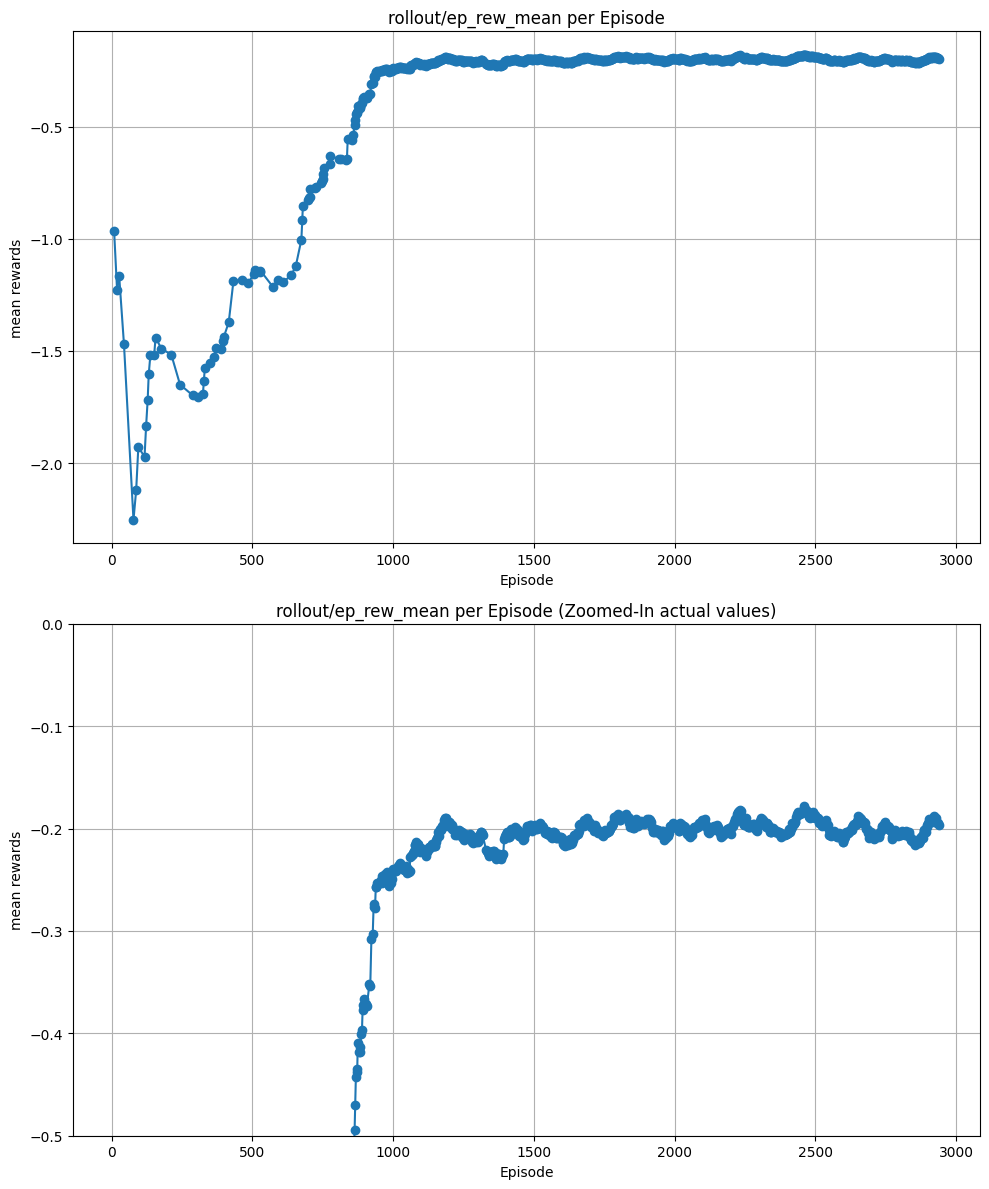

In [29]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_17"
event_file_name = "events.out.tfevents.1714174375.e7c5f58cd75a.12068.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/ep_rew_mean'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot) 

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step / 34 for event in scalar_events]
    episode_values = [event.value / 34 for event in scalar_events]

    # Create subplots with two axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the full-size figure
    ax1.plot(episode_steps, episode_values, marker='o', linestyle='-')
    ax1.set_title(f'{tag_to_plot} per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('mean rewards')
    ax1.grid(True)

    # Zoomed-in plot on y-axis
    ax2.plot(episode_steps, episode_values, marker='o', linestyle='-')
    ax2.set_title(f'{tag_to_plot} per Episode (Zoomed-In actual values)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('mean rewards')
    ax2.grid(True)
    ax2.set_ylim(-0.5, 0)  # Set y-axis limit for zoomed-in plot

    # Adjust layout and display plots
    plt.tight_layout()
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


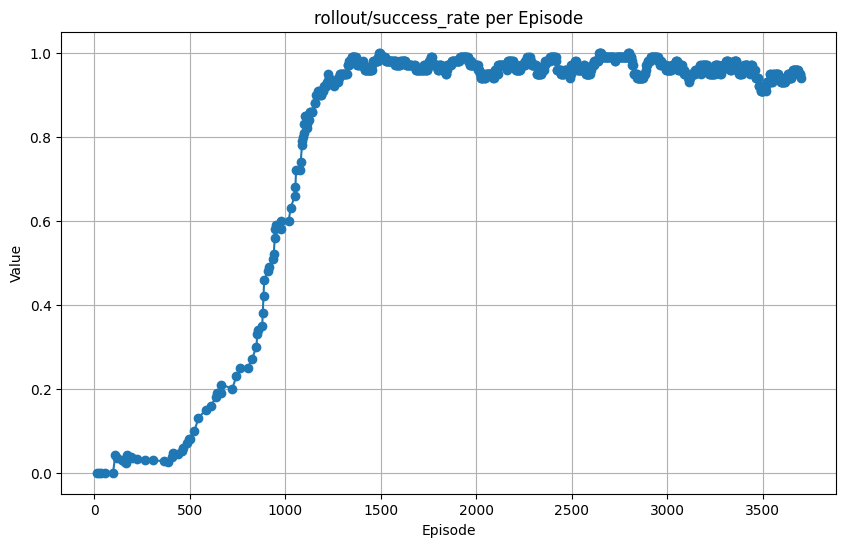

In [14]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_17"
event_file_name = "events.out.tfevents.1714174375.e7c5f58cd75a.12068.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/success_rate'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/27 for event in scalar_events]
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


### Effects of hyperparameter tuning 

After doubling the **learning_steps** parameter from 50,000 to 100,000, the trained model exhibited notable improvements across several key aspects. The extended training duration contributed to enhanced convergence and stability, resulting in a smoother learning process. 

The agent demonstrated a more refined and robust policy, showcasing improved performance metrics such as higher episode rewards, increased success rates, and more consistent behavior across different scenarios. This prolonged training not only facilitated deeper exploration of the environment but also enabled the agent to learn complex strategies and generalize better to new situations. 

Overall, the adjustment in learning_steps led to a more capable and reliable model, reflecting the benefits of extended training in reinforcement learning tasks.

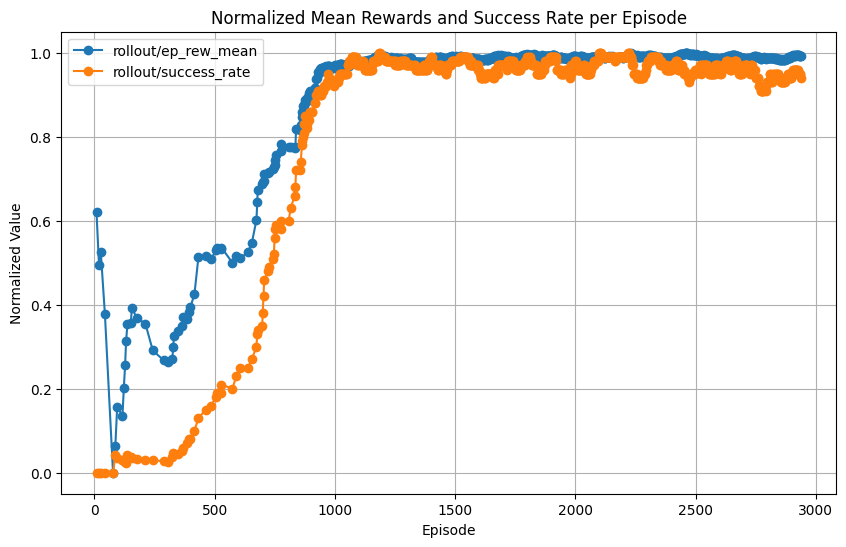

In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_17"
event_file_name = "events.out.tfevents.1714174375.e7c5f58cd75a.12068.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tags for the scalar values to plot
tags_to_plot = ['rollout/ep_rew_mean', 'rollout/success_rate']

# Check if the specified tags exist in the event file
tags = event_acc.Tags()

# Check if all specified tags are found in the event file
if all(tag in tags['scalars'] for tag in tags_to_plot):
    plt.figure(figsize=(10, 6))

    for tag_to_plot in tags_to_plot:
        # Extract scalar events for the specified tag
        scalar_events = event_acc.Scalars(tag_to_plot)

        # Extract episode steps and values for the specified tag
        episode_steps = [event.step / 34 for event in scalar_events]
        episode_values = [event.value / 34 for event in scalar_events]

        # Normalize values between 0 and 1
        normalized_values = (episode_values - np.min(episode_values)) / (np.max(episode_values) - np.min(episode_values))

        # Plot the normalized scalar value per episode
        plt.plot(episode_steps, normalized_values, marker='o', linestyle='-', label=tag_to_plot)

    plt.title('Normalized Mean Rewards and Success Rate per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    missing_tags = [tag for tag in tags_to_plot if tag not in tags['scalars']]
    print(f"Tags '{', '.join(missing_tags)}' not found in the event file.")


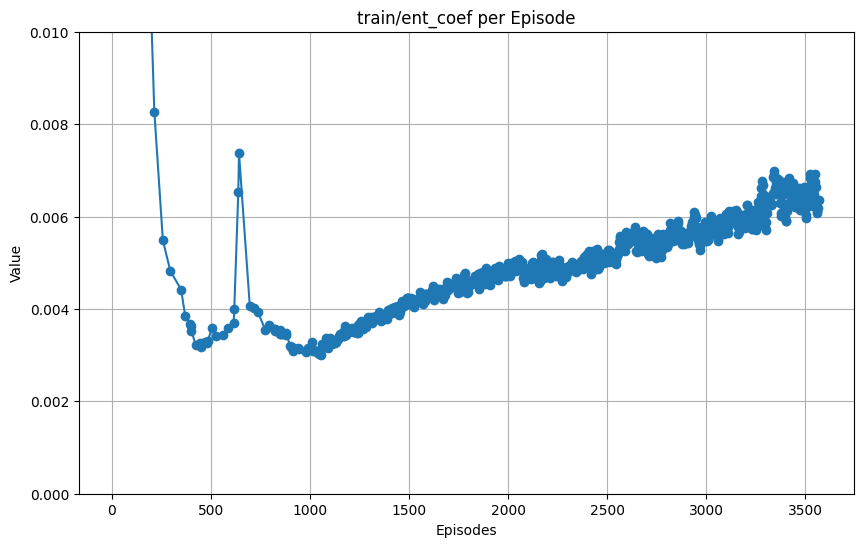

In [17]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_17"
event_file_name = "events.out.tfevents.1714174375.e7c5f58cd75a.12068.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/ent_coef')
tag_to_plot = 'train/ent_coef'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step / 28 for event in scalar_events]  # Divide episode steps by 8
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Value')
    plt.grid(True)

    # Set y-axis limits to zoom in to values between 0 and 0.01
    plt.ylim(0, 0.01)

    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


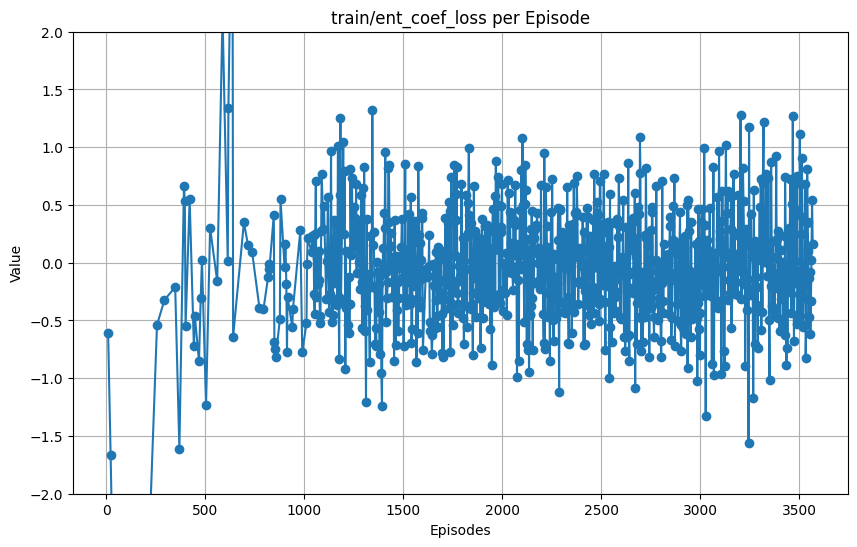

In [23]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_17"
event_file_name = "events.out.tfevents.1714174375.e7c5f58cd75a.12068.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/ent_coef')
tag_to_plot = 'train/ent_coef_loss'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/28  for event in scalar_events]  # Divide episode steps by 8
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Value')
    plt.grid(True)

    # Set y-axis limits to zoom in to values between 0 and 0.01
    plt.ylim(-2, 2)

    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


In [ ]:
!pip install --upgrade jupyter
!pip install --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install --upgrade tqdm


In [5]:
#@title Visualize a few episodes

N_EPISODES = 12  # @param {type: "integer"}

env = gym.make('parking-v0', render_mode='rgb_array')
env = record_videos(env)
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

Test episodes:   0%|          | 0/12 [00:00<?, ?it/s]

Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4




t:  82%|████████▏ | 53/65 [00:00<00:00, 147.03it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4




t:  96%|█████████▌| 51/53 [00:00<00:00, 141.73it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4




t:  87%|████████▋ | 54/62 [00:00<00:00, 140.94it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4




t:  92%|█████████▏| 68/74 [00:00<00:00, 149.20it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4




t: 100%|██████████| 71/71 [00:00<00:00, 154.96it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4




t:  92%|█████████▏| 57/62 [00:00<00:00, 150.72it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4




t:  91%|█████████ | 40/44 [00:00<00:00, 185.32it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4




t:  96%|█████████▋| 54/56 [00:00<00:00, 153.93it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4




t:  68%|██████▊   | 44/65 [00:00<00:00, 216.51it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4




t:  77%|███████▋  | 36/47 [00:00<00:00, 172.87it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4




t:  81%|████████▏ | 74/91 [00:00<00:00, 158.27it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4




t:  72%|███████▏  | 34/47 [00:00<00:00, 166.72it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4


In [6]:
#@title Visualize a few episodes

N_EPISODES = 20  # @param {type: "integer"}

env = gym.make('parking-v0', render_mode='rgb_array')
env = record_videos(env)
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

Test episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4




t:  72%|███████▏  | 36/50 [00:00<00:00, 179.29it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4




t:  87%|████████▋ | 59/68 [00:00<00:00, 163.24it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4




t:  68%|██████▊   | 42/62 [00:00<00:00, 205.31it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4




t:  84%|████████▍ | 57/68 [00:00<00:00, 158.85it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4




t:  86%|████████▌ | 56/65 [00:00<00:00, 163.50it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4




t:  98%|█████████▊| 40/41 [00:00<00:00, 192.61it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4




t:  87%|████████▋ | 54/62 [00:00<00:00, 148.28it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4




t:  96%|█████████▋| 54/56 [00:00<00:00, 139.71it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4




t:  87%|████████▋ | 71/82 [00:00<00:00, 150.91it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4




t:  76%|███████▋  | 45/59 [00:00<00:00, 225.26it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4




t:  86%|████████▋ | 69/80 [00:00<00:00, 155.19it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4




t:  82%|████████▏ | 36/44 [00:00<00:00, 160.72it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-12.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-12.mp4




t:  86%|████████▌ | 56/65 [00:00<00:00, 157.02it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-12.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-13.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-13.mp4




t:  85%|████████▌ | 40/47 [00:00<00:00, 176.92it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-13.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-14.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-14.mp4




t:  92%|█████████▏| 60/65 [00:00<00:00, 150.19it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-14.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-15.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-15.mp4




t:  70%|███████   | 35/50 [00:00<00:00, 172.99it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-15.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-16.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-16.mp4




t:  74%|███████▍  | 46/62 [00:00<00:00, 227.78it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-16.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-17.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-17.mp4




t:  85%|████████▍ | 72/85 [00:00<00:00, 155.48it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-17.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-18.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-18.mp4




t:  88%|████████▊ | 44/50 [00:00<00:00, 188.04it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-18.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-19.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-19.mp4




t:  97%|█████████▋| 72/74 [00:00<00:00, 158.94it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-19.mp4


In [7]:

#@title Visualize a few episodes

N_EPISODES = 50  # @param {type: "integer"}

env = gym.make('parking-v0', render_mode='rgb_array')
env = record_videos(env)
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

Test episodes:   0%|          | 0/50 [00:00<?, ?it/s]

Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4




t:  72%|███████▏  | 34/47 [00:00<00:00, 165.39it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4




t:  89%|████████▉ | 58/65 [00:00<00:00, 152.80it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4




t:  85%|████████▌ | 40/47 [00:00<00:00, 196.68it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4




t:  84%|████████▍ | 67/80 [00:00<00:00, 164.46it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4




t:  79%|███████▊  | 37/47 [00:00<00:00, 180.11it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4




t:  84%|████████▍ | 42/50 [00:00<00:00, 179.81it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4




t:  88%|████████▊ | 36/41 [00:00<00:00, 165.36it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4




t:  71%|███████▏  | 40/56 [00:00<00:00, 187.42it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4




t:  92%|█████████▏| 71/77 [00:00<00:00, 156.14it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4




t:  91%|█████████ | 51/56 [00:00<00:00, 154.94it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4




t:  73%|███████▎  | 43/59 [00:00<00:00, 207.84it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4




t:  83%|████████▎ | 64/77 [00:00<00:00, 183.92it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-12.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-12.mp4




t:  94%|█████████▍| 47/50 [00:00<00:00, 233.18it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-12.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-13.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-13.mp4




t:  97%|█████████▋| 57/59 [00:00<00:00, 155.99it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-13.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-14.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-14.mp4




t: 100%|██████████| 41/41 [00:00<00:00, 200.04it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-14.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-15.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-15.mp4




t:  81%|████████  | 71/88 [00:00<00:00, 157.14it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-15.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-16.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-16.mp4




t:  98%|█████████▊| 55/56 [00:00<00:00, 151.88it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-16.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-17.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-17.mp4




t:  78%|███████▊  | 66/85 [00:00<00:00, 153.24it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-17.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-18.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-18.mp4




t:  99%|█████████▉| 90/91 [00:00<00:00, 156.47it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-18.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-19.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-19.mp4




t:  85%|████████▍ | 55/65 [00:00<00:00, 143.40it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-19.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-20.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-20.mp4




t:  70%|███████   | 35/50 [00:00<00:00, 170.90it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-20.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-21.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-21.mp4




t:  94%|█████████▎| 88/94 [00:00<00:00, 155.40it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-21.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-22.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-22.mp4




t:  79%|███████▉  | 56/71 [00:00<00:00, 146.43it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-22.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-23.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-23.mp4




t:  91%|█████████ | 59/65 [00:00<00:00, 157.58it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-23.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-24.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-24.mp4




t:  80%|███████▉  | 59/74 [00:00<00:00, 151.71it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-24.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-25.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-25.mp4




t:  79%|███████▉  | 56/71 [00:00<00:00, 152.26it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-25.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-26.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-26.mp4




t:  74%|███████▍  | 48/65 [00:00<00:00, 139.15it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-26.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-27.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-27.mp4




t:  77%|███████▋  | 48/62 [00:00<00:00, 174.39it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-27.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-28.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-28.mp4




t: 100%|██████████| 85/85 [00:00<00:00, 150.76it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-28.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-29.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-29.mp4




t:  73%|███████▎  | 43/59 [00:00<00:00, 210.68it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-29.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-30.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-30.mp4




t:  97%|█████████▋| 57/59 [00:00<00:00, 156.90it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-30.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-31.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-31.mp4




t:  91%|█████████ | 40/44 [00:00<00:00, 189.47it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-31.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-32.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-32.mp4




t:  79%|███████▊  | 37/47 [00:00<00:00, 181.86it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-32.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-33.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-33.mp4




t:  86%|████████▌ | 48/56 [00:00<00:00, 190.88it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-33.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-34.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-34.mp4




t:  85%|████████▌ | 75/88 [00:00<00:00, 154.46it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-34.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-35.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-35.mp4




t:  72%|███████▏  | 36/50 [00:00<00:00, 175.23it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-35.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-36.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-36.mp4




t:  92%|█████████▏| 54/59 [00:00<00:00, 145.59it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-36.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-37.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-37.mp4




t:  96%|█████████▌| 90/94 [00:00<00:00, 156.86it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-37.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-38.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-38.mp4




t:  85%|████████▍ | 60/71 [00:00<00:00, 167.80it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-38.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-39.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-39.mp4




t:  89%|████████▉ | 58/65 [00:00<00:00, 152.71it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-39.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-40.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-40.mp4




t:  88%|████████▊ | 65/74 [00:00<00:00, 151.44it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-40.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-41.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-41.mp4




t:  76%|███████▌  | 38/50 [00:00<00:00, 176.63it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-41.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-42.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-42.mp4




t:  85%|████████▌ | 35/41 [00:00<00:00, 170.12it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-42.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-43.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-43.mp4




t:  74%|███████▍  | 35/47 [00:00<00:00, 171.84it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-43.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-44.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-44.mp4




t: 100%|██████████| 59/59 [00:00<00:00, 153.25it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-44.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-45.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-45.mp4




t:  85%|████████▌ | 40/47 [00:00<00:00, 199.49it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-45.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-46.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-46.mp4




t:  91%|█████████ | 40/44 [00:00<00:00, 179.67it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-46.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-47.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-47.mp4




t: 100%|██████████| 38/38 [00:00<00:00, 175.11it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-47.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-48.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-48.mp4




t:  93%|█████████▎| 55/59 [00:00<00:00, 148.56it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-48.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-49.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-49.mp4




t:  85%|████████▌ | 53/62 [00:00<00:00, 136.30it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-49.mp4


## pip install moviepy